## Importing Libraries

In [2]:
import os
import shutil
from pathlib import Path

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import rotate, shift, zoom
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

sns.set_style("white")

## Defining Paths

In [3]:
train_images_path = Path("../data/train_set/images/")
train_labels_path = Path("../data/train_set/labels/")

## Function to Make Development Splits

In [4]:
def make_development_splits(train_set: pd.DataFrame, save_path: Path, n_folds: int = 5):
    """Split training set into n folds at a patient-level."""
    np.random.seed(2023)

    # Create save path if it doesn't exist
    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True, parents=True)

    # Get unique patient ids and their corresponding labels
    pids = train_set.patientid.unique()
    labs = np.array([train_set[train_set.patientid == pid].malignancy.values[0] for pid in pids])
    # Uncomment the line below to stratify based on nodule type
    # labs = np.array([train_set[train_set.patientid == pid].noduletype.values[0] for pid in pids])

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_folds)
    skf.get_n_splits(pids, labs)
    folds_missing = False

    # Check if all folds are present
    for idx in range(n_folds):
        train_pd = save_path / f"train{idx}.csv"
        valid_pd = save_path / f"valid{idx}.csv"
        # If any of the fold is missing, set the flag to True
        if not train_pd.is_file():
            folds_missing = True
        if not valid_pd.is_file():
            folds_missing = True

    # If any of the fold is missing, create all folds
    if folds_missing:
        print(f"Making {n_folds} folds from the train set")
        # Create n folds from the train set
        for idx, (train_index, test_index) in enumerate(skf.split(pids, labs)):
            train_pids, valid_pids = pids[train_index], pids[test_index]
            # Filter the train and valid sets
            train_pd = train_set[train_set.patientid.isin(train_pids)]
            valid_pd = train_set[train_set.patientid.isin(valid_pids)]
            # Reset the index
            train_pd = train_pd.reset_index(drop=True)
            valid_pd = valid_pd.reset_index(drop=True)
            # Save the train and valid sets
            train_pd.to_csv(save_path / f"train{idx}.csv", index=False)
            valid_pd.to_csv(save_path / f"valid{idx}.csv", index=False)

### Load Training Data and Make Development Splits

In [ ]:
train_df_path = "../data/luna23-ismi-train-set.csv"
train_df = pd.read_csv(train_df_path)

make_development_splits(train_df, "../data/train_val")

### Load Sample Image

In [27]:
def load_sample_image(nodule_id):
    """Load a sample image from the dataset."""
    image = sitk.ReadImage(str(train_images_path / f"{nodule_id}.mha"))
    image_patch = sitk.GetArrayFromImage(image)
    return image_patch

### Define Augmentation Functions

In [28]:
def apply_rotation(image, angle):
    """Apply rotation to the image."""
    return rotate(image, angle, axes=(1, 2), reshape=False)


def apply_translation(image, shift_val):
    """Apply translation to the image."""
    return shift(image, shift_val)


def apply_flipping(image, axis):
    """Apply flipping to the image."""
    return np.flip(image, axis=axis)


def apply_scaling(image, scale):
    """Apply scaling to the image."""
    return zoom(image, scale)

### Apply Augmentations and Visualize to Sample Image

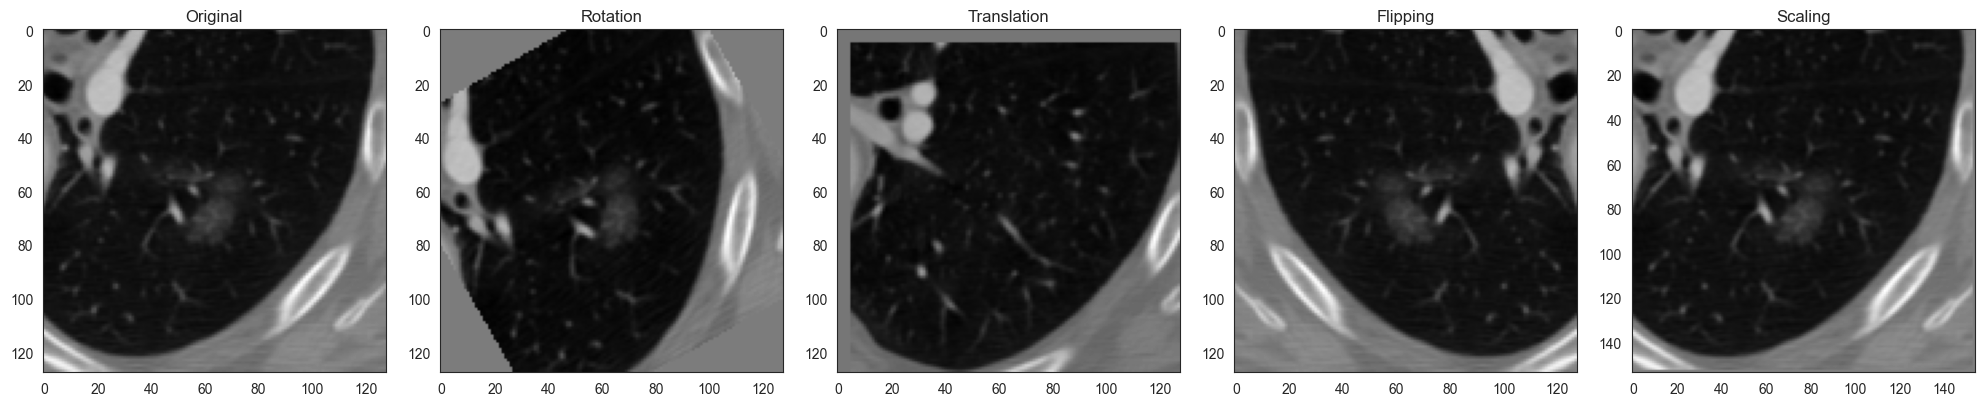

In [29]:
# Load sample images
ground_glass_sample = load_sample_image(train_df[train_df['noduletype'] == 'GroundGlassOpacity'].iloc[0]['noduleid'])

# Define and apply augmentations
augmentations = {
    "Rotation": apply_rotation(ground_glass_sample, 30),
    "Translation": apply_translation(ground_glass_sample, (5, 5, 5)),
    "Flipping": apply_flipping(ground_glass_sample, axis=2),
    "Scaling": apply_scaling(ground_glass_sample, (1, 1.2, 1.2))
}

# Visualize augmentations
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(ground_glass_sample[32], cmap='gray')
ax[0].set_title('Original')
for i, (aug_name, aug_img) in enumerate(augmentations.items()):
    ax[i + 1].imshow(aug_img[32], cmap='gray')
    ax[i + 1].set_title(aug_name)
plt.tight_layout()
plt.show()

### Augment Dataset for Specific Class

In [30]:
def augment_class(train_df, train_images_path, target_class, class_column, target_count):
    """Augment dataset for specific class."""
    augmented_data = []
    class_df = train_df[train_df[class_column] == target_class]
    for _, row in tqdm(class_df.iterrows(), total=len(class_df)):
        image_patch = load_sample_image(row['noduleid'])
        for _ in range(target_count // len(class_df)):
            augmented_image = apply_rotation(image_patch, np.random.uniform(-30, 30))
            augmented_image = apply_translation(augmented_image, np.random.uniform(-5, 5, size=3))
            augmented_image = apply_flipping(augmented_image, axis=np.random.choice([0, 1, 2]))
            augmented_image = apply_scaling(augmented_image,
                                            (1, np.random.uniform(0.9, 1.1), np.random.uniform(0.9, 1.1)))
            augmented_data.append((augmented_image, row))

    return augmented_data

### Save Augmented Data

In [31]:
def save_augmented_data(augmented_data, images_path, labels_path, csv_path, original_df):
    """Save augmented data to disk and update the CSV file."""
    existing_rows = []

    # Copy existing data
    for _, row in original_df.iterrows():
        existing_rows.append(row.to_dict())
        shutil.copy(train_images_path / f"{row['noduleid']}.mha", images_path / f"{row['noduleid']}.mha")
        shutil.copy(train_labels_path / f"{row['noduleid']}.mha", labels_path / f"{row['noduleid']}.mha")

    # Save augmented data
    new_rows = []
    for i, (augmented_image, original_row) in enumerate(augmented_data):
        new_nodule_id = f"aug_nodule_{i}"
        image_path = images_path / f"{new_nodule_id}.mha"
        label_path = labels_path / f"{new_nodule_id}.mha"

        # Save the image
        image = sitk.GetImageFromArray(augmented_image)
        sitk.WriteImage(image, str(image_path))

        # Assuming label is available and saved in a similar manner
        label = sitk.GetImageFromArray(np.zeros_like(augmented_image))
        sitk.WriteImage(label, str(label_path))

        new_row = original_row.copy()
        new_row['noduleid'] = new_nodule_id
        new_rows.append(new_row)

    # Update the CSV file
    updated_df = pd.DataFrame(existing_rows + new_rows)
    updated_df.to_csv(csv_path, index=False)

### Augment and Save Data for Each Folder 

In [32]:
folders = ["train0", "train1", "train2", "train3", "train4", "valid0", "valid1", "valid2", "valid3", "valid4"]

### Balancing Dataset for Nodule Types

In [33]:
for folder in folders:
    train_df_path = f"../data/train_val/{folder}.csv"
    train_df = pd.read_csv(train_df_path)
    # Define target count based on majority class for nodule types
    target_count_noduletype = train_df['noduletype'].value_counts().max()

    # Augment dataset for nodule types
    augmented_data_noduletype = []
    for target_class in train_df['noduletype'].value_counts().index:
        if train_df['noduletype'].value_counts()[target_class] < target_count_noduletype:
            augmented_data_noduletype.extend(
                augment_class(train_df, train_images_path, target_class, 'noduletype', target_count_noduletype))

    # Convert augmented data to DataFrame
    augmented_rows = []
    for augmented_image, original_row in augmented_data_noduletype:
        new_row = original_row.copy()
        new_row['noduleid'] = f"aug_nodule_{len(augmented_rows)}"
        augmented_rows.append(new_row)

    augmented_df_noduletype = pd.DataFrame(augmented_rows)

    # Concatenate with original dataset
    balanced_train_df_noduletype = pd.concat([train_df, augmented_df_noduletype])

    # Create directories for nodule balanced dataset
    os.makedirs(f"../data/train_val/noduletype_balanced/{folder}/train_set/images", exist_ok=True)
    os.makedirs(f"../data/train_val/noduletype_balanced/{folder}/train_set/labels", exist_ok=True)

    # Save augmented data for nodule types
    save_augmented_data(
        augmented_data_noduletype,
        Path(f"../data/train_val/noduletype_balanced/{folder}/train_set/images"),
        Path(f"../data/train_val/noduletype_balanced/{folder}/train_set/labels"),
        Path(f"../data/train_val/noduletype_balanced/{folder}/luna23-ismi-train-set.csv"),
        train_df)

100%|██████████| 5/5 [01:11<00:00, 14.22s/it]


### Balancing Dataset for Malignancy

In [50]:
for folder in folders:
    train_df_path = f"../data/train_val/{folder}.csv"
    train_df = pd.read_csv(train_df_path)
    # Define target count based on majority class for malignancy
    target_count_malignancy = train_df['malignancy'].value_counts().max()

    # Augment dataset for malignancy
    augmented_data_malignancy = []
    for target_class in train_df['malignancy'].value_counts().index:
        if train_df['malignancy'].value_counts()[target_class] < target_count_malignancy:
            augmented_data_malignancy.extend(
                augment_class(train_df, train_images_path, target_class, 'malignancy', target_count_malignancy))

    # Convert augmented data to DataFrame
    augmented_rows_malignancy = []
    for augmented_image, original_row in augmented_data_malignancy:
        new_row = original_row.copy()
        new_row['noduleid'] = f"aug_nodule_{len(augmented_rows_malignancy)}"
        augmented_rows_malignancy.append(new_row)

    augmented_df_malignancy = pd.DataFrame(augmented_rows_malignancy)

    # Concatenate with original dataset
    balanced_train_df_malignancy = pd.concat([train_df, augmented_df_malignancy])

    # Create directories for malignancy balanced dataset
    os.makedirs(f"../data/train_val/malignancy_balanced/{folder}/train_set/images", exist_ok=True)
    os.makedirs(f"../data/train_val/malignancy_balanced/{folder}/train_set/labels", exist_ok=True)

    # Save augmented data for malignancy
    save_augmented_data(
        augmented_data_malignancy,
        Path(f"../data/train_val/malignancy_balanced/{folder}/train_set/images"),
        Path(f"../data/train_val/malignancy_balanced/{folder}/train_set/labels"),
        Path(f"../data/train_val/malignancy_balanced/{folder}/luna23-ismi-train-set.csv"),
        train_df)

100%|██████████| 39/39 [01:03<00:00,  1.64s/it]


### Visualizing Data Distribution
#### Original vs Balanced Data Distribution for fold 0 - Nodule Types

In [53]:
# Define the color palette for consistent coloring
color_palette = {
    "Solid": "#1f77b4",        # Blue
    "GroundGlassOpacity": "#ff7f0e",  # Orange
    "Calcified": "#2ca02c",    # Green
    "SemiSolid": "#d62728"     # Red
}

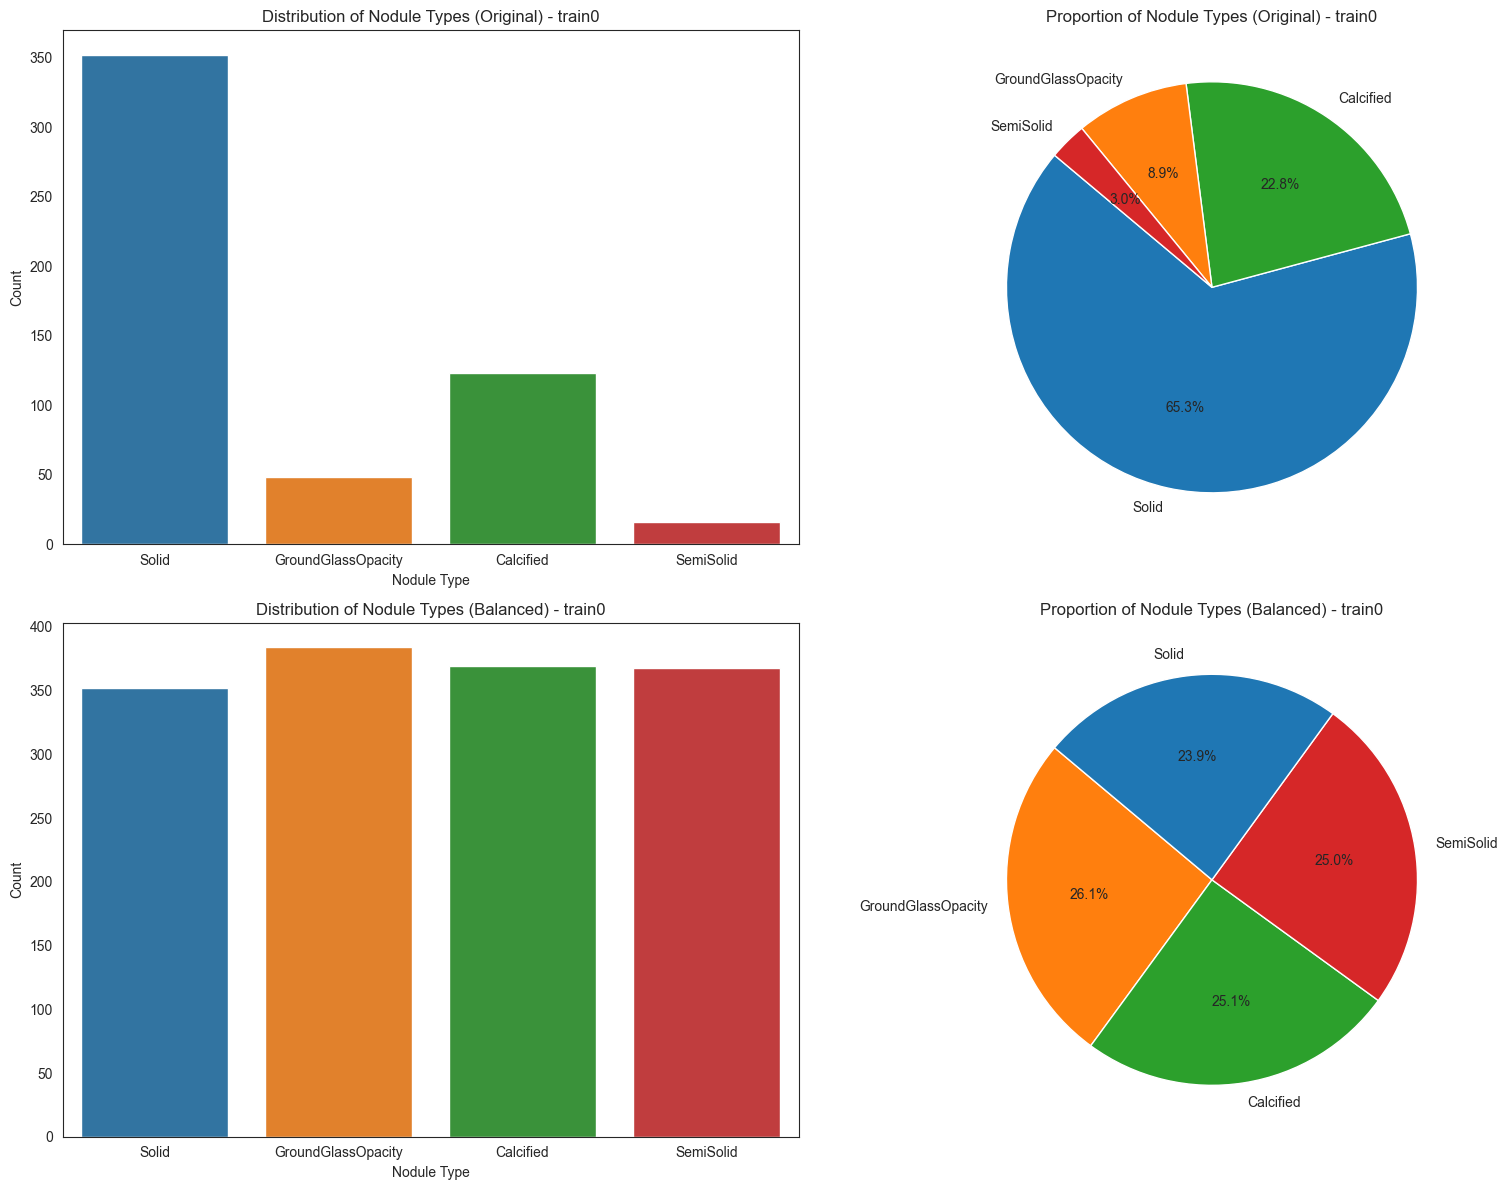

Nodule Type Percentages - train0
Nodule Type Percentages (Original):
Solid                 65.306122
Calcified             22.820037
GroundGlassOpacity     8.905380
SemiSolid              2.968460
Name: noduletype, dtype: float64

Nodule Type Percentages (Balanced):
GroundGlassOpacity    26.069246
Calcified             25.050916
SemiSolid             24.983028
Solid                 23.896809
Name: noduletype, dtype: float64


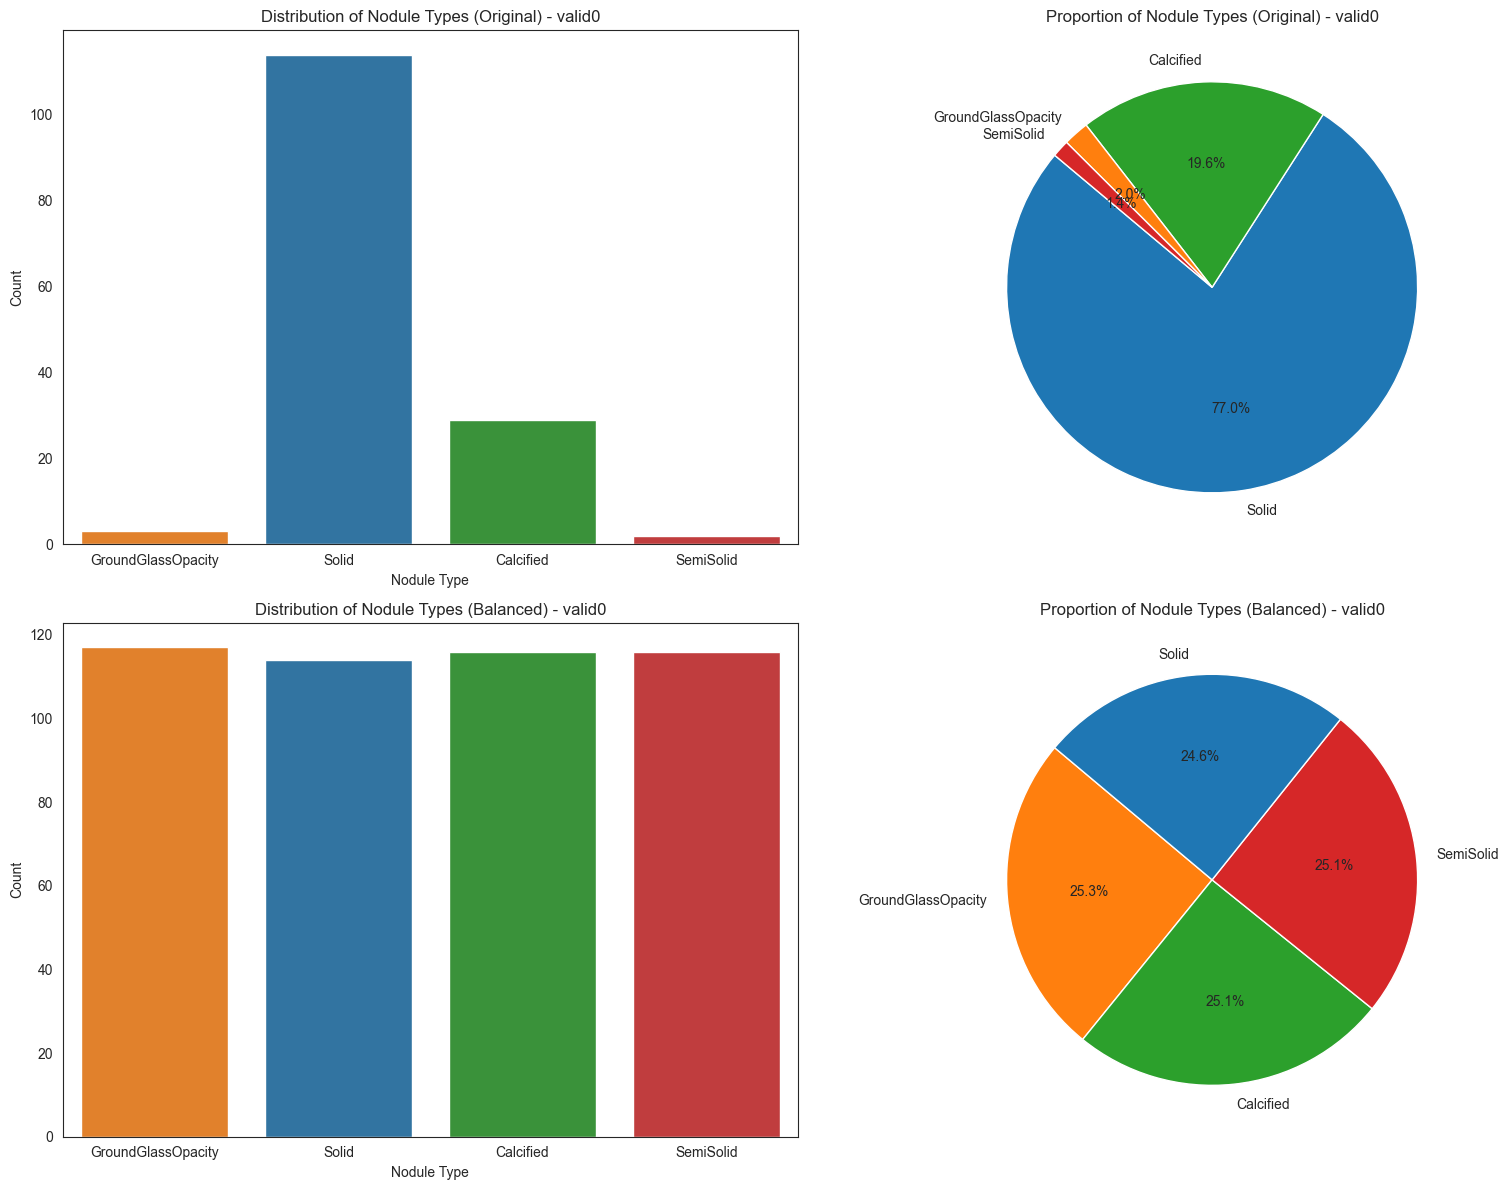

Nodule Type Percentages - valid0
Nodule Type Percentages (Original):
Solid                 77.027027
Calcified             19.594595
GroundGlassOpacity     2.027027
SemiSolid              1.351351
Name: noduletype, dtype: float64

Nodule Type Percentages (Balanced):
GroundGlassOpacity    25.269978
Calcified             25.053996
SemiSolid             25.053996
Solid                 24.622030
Name: noduletype, dtype: float64


In [54]:
for folder in ["train0", "valid0"]:
    # Load original and balanced datasets
    train_df = pd.read_csv(f"../data/train_val/{folder}.csv")
    balanced_train_df_noduletype = pd.read_csv(f"../data/train_val/noduletype_balanced/{folder}/luna23-ismi-train-set.csv")

    # Original Data Distribution
    noduletype_counts_original = train_df['noduletype'].value_counts()

    # Class Distribution Count Plots for Nodule Types (Before and After)
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    sns.countplot(x='noduletype', data=train_df, ax=ax[0, 0], palette=color_palette)
    ax[0, 0].set_title(f'Distribution of Nodule Types (Original) - {folder}')
    ax[0, 0].set_xlabel('Nodule Type')
    ax[0, 0].set_ylabel('Count')

    ax[0, 1].pie(noduletype_counts_original, labels=noduletype_counts_original.index, autopct='%1.1f%%', startangle=140,
                 colors=[color_palette[label] for label in noduletype_counts_original.index])
    ax[0, 1].set_title(f'Proportion of Nodule Types (Original) - {folder}') 

    sns.countplot(x='noduletype', data=balanced_train_df_noduletype, ax=ax[1, 0], palette=color_palette)
    ax[1, 0].set_title(f'Distribution of Nodule Types (Balanced) - {folder}')
    ax[1, 0].set_xlabel('Nodule Type')
    ax[1, 0].set_ylabel('Count')

    noduletype_counts_noduletype_balanced = balanced_train_df_noduletype['noduletype'].value_counts()
    ax[1, 1].pie(noduletype_counts_noduletype_balanced, labels=noduletype_counts_noduletype_balanced.index,
                 autopct='%1.1f%%', startangle=140,
                 colors=[color_palette[label] for label in noduletype_counts_noduletype_balanced.index])
    ax[1, 1].set_title(f'Proportion of Nodule Types (Balanced) - {folder}')

    plt.tight_layout()
    plt.show()

    print(f"Nodule Type Percentages - {folder}")
    print("Nodule Type Percentages (Original):")
    print(noduletype_counts_original / noduletype_counts_original.sum() * 100)
    print("\nNodule Type Percentages (Balanced):")
    print(noduletype_counts_noduletype_balanced / noduletype_counts_noduletype_balanced.sum() * 100)

#### Original vs Balanced Data Distribution for fold 0 - Malignancy

In [62]:
color_palette = {
    0: "#1f77b4",  # Blue
    1: "#d62728",  # Red
}

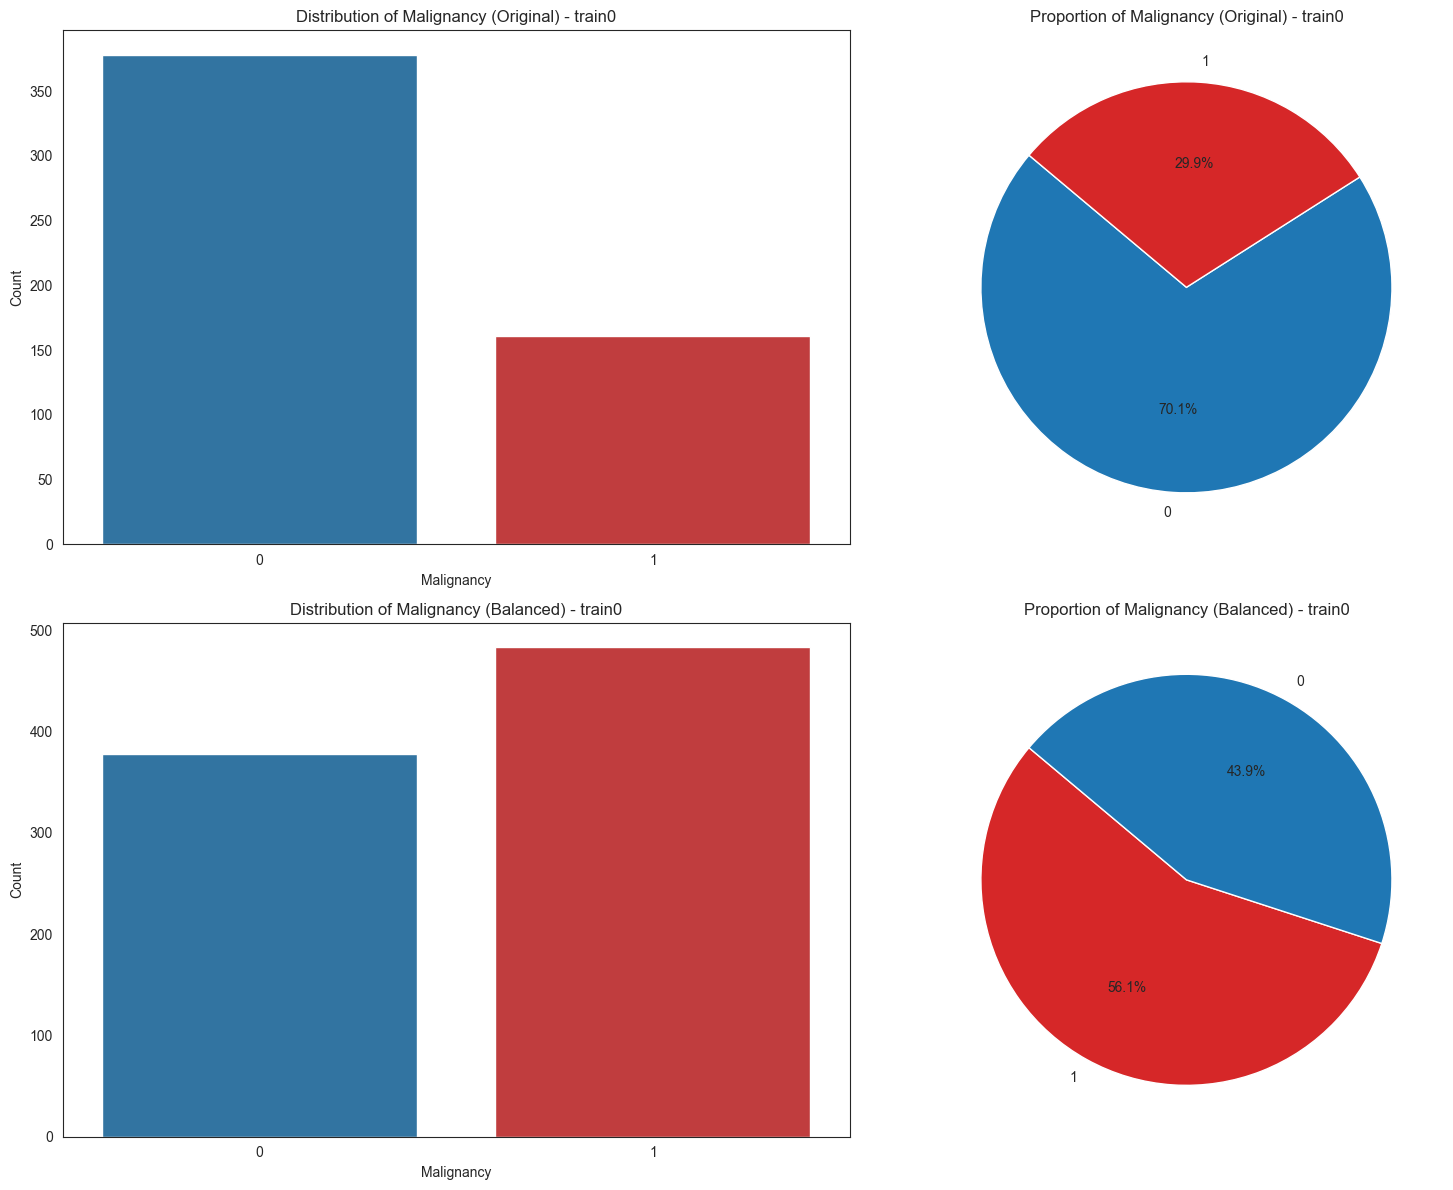

Malignancy Percentages - train0
Malignancy Percentages (Original):
0    70.12987
1    29.87013
Name: malignancy, dtype: float64

Malignancy Percentages (Balanced):
1    56.097561
0    43.902439
Name: malignancy, dtype: float64


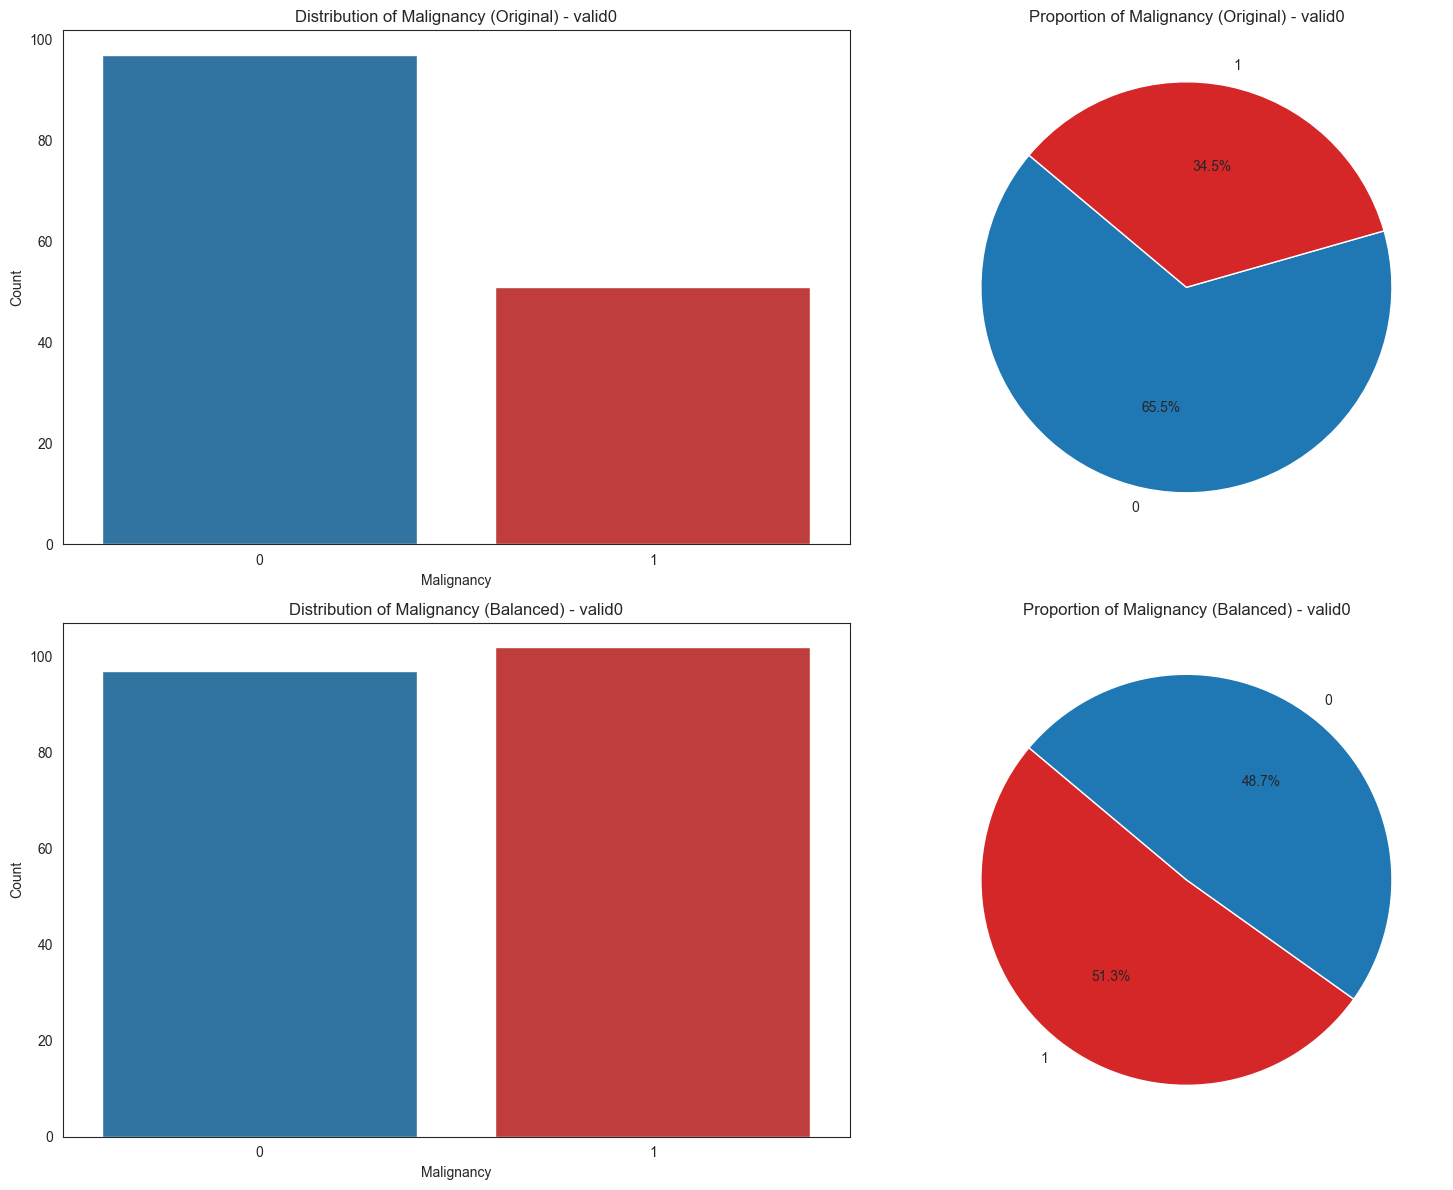

Malignancy Percentages - valid0
Malignancy Percentages (Original):
0    65.540541
1    34.459459
Name: malignancy, dtype: float64

Malignancy Percentages (Balanced):
1    51.256281
0    48.743719
Name: malignancy, dtype: float64


In [65]:
for folder in ["train0", "valid0"]:
    # Load original and balanced datasets
    train_df = pd.read_csv(f"../data/train_val/{folder}.csv")
    balanced_train_df_malignancy = pd.read_csv(f"../data/train_val/malignancy_balanced/{folder}/luna23-ismi-train-set.csv")
    
    # Original Data Distribution
    malignancy_counts_original = train_df['malignancy'].value_counts()
    
    # Class Distribution Count Plots for Malignancy (Before and After)
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    sns.countplot(x='malignancy', data=train_df, ax=ax[0, 0], palette=color_palette)
    ax[0, 0].set_title(f'Distribution of Malignancy (Original) - {folder}')
    ax[0, 0].set_xlabel('Malignancy')
    ax[0, 0].set_ylabel('Count')

    ax[0, 1].pie(malignancy_counts_original, labels=malignancy_counts_original.index, autopct='%1.1f%%', startangle=140,
                 colors=[color_palette[label] for label in malignancy_counts_original.index])
    ax[0, 1].set_title(f'Proportion of Malignancy (Original) - {folder}')
    
    
    malignancy_counts_malignancy_balanced = balanced_train_df_malignancy['malignancy'].value_counts()
    
    sns.countplot(x='malignancy', data=balanced_train_df_malignancy, ax=ax[1, 0], palette=color_palette)
    ax[1, 0].set_title(f'Distribution of Malignancy (Balanced) - {folder}')
    ax[1, 0].set_xlabel('Malignancy')
    ax[1, 0].set_ylabel('Count')
    
    ax[1, 1].pie(malignancy_counts_malignancy_balanced, labels=malignancy_counts_malignancy_balanced.index,
                 autopct='%1.1f%%', startangle=140,
                 colors=[color_palette[label] for label in malignancy_counts_malignancy_balanced.index])
    ax[1, 1].set_title(f'Proportion of Malignancy (Balanced) - {folder}')

    plt.tight_layout()
    plt.show()

    print(f"Malignancy Percentages - {folder}")
    print("Malignancy Percentages (Original):")
    print(malignancy_counts_original / malignancy_counts_original.sum() * 100)
    print("\nMalignancy Percentages (Balanced):")
    print(malignancy_counts_malignancy_balanced / malignancy_counts_malignancy_balanced.sum() * 100)